# Approach 3: MAB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm

In [2]:
# Fixate the global random seed
SEED = 0
np.random.seed(SEED)

## Training

###  Data Preprocessing

In [3]:
TRAIN_PATH = 'data/train.csv'

df_train = pd.read_csv(TRAIN_PATH)

In [4]:
print("> Quick visual check of dataframe:") 
df_train.head()

> Quick visual check of dataframe:


,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime


In [5]:
mask_young = df_train['user_age'] < 30
mask_male = df_train['user_gender'] == "M"

df_user_my = df_train[mask_male & mask_young]
df_user_mo = df_train[mask_male & ~mask_young]
df_user_fy = df_train[~mask_male & mask_young]
df_user_fo = df_train[~mask_male & ~mask_young]

df_user_groups = {
    'my' : df_user_my,
    'mo' : df_user_mo,
    'fy' : df_user_fy,
    'fo' : df_user_fo
}



In [6]:
df_user_groups['my']

,user_id,item_id,rating,user_age,user_gender,user_occupation,user_zip,release_date,genre
0,1,1,5,24,M,technician,Arizona,1995.0,Animation
1,1,2,3,24,M,technician,Arizona,1995.0,Action
2,1,3,4,24,M,technician,Arizona,1995.0,Thriller
3,1,4,3,24,M,technician,Arizona,1995.0,Action
4,1,5,3,24,M,technician,Arizona,1995.0,Crime
...,...,...,...,...,...,...,...,...,...
90565,943,1047,2,22,M,student,Texas,1996.0,Comedy
90566,943,1074,4,22,M,student,Texas,1994.0,Comedy
90567,943,1188,3,22,M,student,Texas,1990.0,Action
90568,943,1228,3,22,M,student,Texas,1995.0,Action


In [7]:
# TODO generalise to all four groups. For development purposes we start by restricting ourselves to only the `my` dataframe.

In [8]:
df = df_user_my.copy(deep=True)

In [9]:
df.drop(
    columns=['user_age','user_gender','user_occupation','user_zip','release_date','genre'], inplace=True
    )
df.head()

,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [14]:
df['liked'] = df['rating'] >= 4 
df.drop(
    columns=['rating'], 
    inplace=True
    )

KeyError: 'rating'

In [15]:
df.head()

,user_id,item_id,liked
0,1,1,True
1,1,2,False
2,1,3,True
3,1,4,False
4,1,5,False


#### Define MAB Structure

In [46]:
class EpsilonTrainer(object):
    """ Assumptions 
        -   the reward database is freshly reindexed (i.e. discrete 0,1,.. without jumps)
            => used when indexing into the user/item column
            
    """
    
    
    
    def __init__(self, epsilon, 
                 reward_database, item_col_name, user_col_name, reward_col_name,
                 n_recommendations,
                 n_iterations = 1):
        
        print("> Starting MAB machine.")
        ''' Save arguments to object-instance '''
        self.epsilon = epsilon  # greediness
        self.reward_database = reward_database  # used to access the ratings
        self.item_col_name = item_col_name  # header name of item column in that db
        self.user_col_name = user_col_name  # header name of user column in that db
        self.reward_col_name = reward_col_name
        self.n_recommendations = n_recommendations  # number of recs for training the MAB machine
        self.n_iterations = n_iterations  # number of iterations performed subsequently to reduce variance; investigate statistical differences # TODO [analyse, investigate]
        
        ''' Setup subviews of interest '''
        self.items = self.reward_database[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        self.users = self.reward_database[self.user_col_name].unique()
        self.n_users = len(self.users)
        
        print(">> Initialized.")
    
    def reset(self):
        ''' (Re-)Initialise the learnt data for next iteration '''
        self.item_counter_arr = np.zeros(self.n_items)  # count how often each item appeared
        self.item_reward_arr = np.zeros(self.n_items)  # accumulated reward per item (in [0,1] range)
        
        print(">>> Reset.")
    
    
    def random_user(self):
        """ returns a user_id for a random user in the the user column of the review_database """
        user_idx = np.random.randint(self.n_users)
        user_id = self.users[user_idx]
        return user_id
    
    def select_item(self):
        """ selects an item from the database with epsilon-greedy strategy """
        
        outcome = np.random.uniform(low=0.0, high=1.0)
        
        if outcome < self.epsilon:
            """ Explore """
            item_idx = np.random.randint(self.n_items)
        else:
            """ Exploit """
            item_idx = np.argmax(self.item_reward_arr)  # TODO check that indeed idx and not an id. would assume idx because array index need not correspond to e.g. the movie id.
        
        item_id = self.items[item_idx]
        return item_id    
        
    def replay(self):
        log = []  # store the results from each iteration
        
        print(">> Starting replay.")
        for iteration in range(0, self.n_iterations):
            ''' initialise '''
            print(">>> Iteration", iteration)
            self.reset()
            
            total_rewards = 0
            like_fraction = np.zeros(self.n_recommendations)
            
            for rec_idx in tqdm(range(0, self.n_recommendations)):
                found_train_tuple = False
                
                while not found_train_tuple:
                    user_id = self.random_user()
                    item_id = self.select_item()

                    # print(f"> User_id: %i, Item_id: %i" % (user_id, item_id))
                    potential_reward = self.reward_database.query('{} == @item_id and {} == @user_id'.format(self.item_col_name, self.user_col_name))[self.reward_col_name]

                    found_train_tuple = potential_reward.shape[0] > 0
                
                reward_value = potential_reward.iloc[0]
                
                
                # Record metrics
                total_rewards += reward_value
                like_fraction[rec_idx] = total_rewards * 1. / (rec_idx + 1)

                result = {}
                result['iteration'] = iteration
                result['recomendation'] = rec_idx
                result['item_id'] = item_id
                result['user_id'] = user_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['like_fraction'] = total_rewards * 1. / (rec_idx + 1)

                log.append(result)
            
        return log
    
    def record_result(self):
        pass
    
    
epsilon = 0.05
n_recommendations = 1000
n_iterations = 1

epsilon_05_results = EpsilonTrainer(
    epsilon=epsilon,
    reward_database=df,
    item_col_name="item_id",
    user_col_name="user_id",
    reward_col_name="liked",
    n_recommendations=n_recommendations,
    n_iterations=n_iterations 
).replay()

df_epsilon_05_results = pd.DataFrame(epsilon_05_results)

> Starting MAB machine.
>> Initialized.
>> Starting replay.
>>> Iteration 0
>>> Reset.


100%|██████████| 1000/1000 [00:02<00:00, 371.03it/s]


In [44]:
print(df_epsilon_05_results)

     iteration  recomendation  item_id  user_id  reward  total_reward  \
0            0              0        1      435    True             1   
1            0              1        1      412    True             2   
2            0              2        1      806    True             3   
3            0              3        1      916    True             4   
4            0              4        1      399    True             5   
..         ...            ...      ...      ...     ...           ...   
995          0            995        1      580   False           691   
996          0            996        1      793    True           692   
997          0            997        1       94    True           693   
998          0            998        1      710    True           694   
999          0            999        1      635    True           695   

     like_fraction  
0         1.000000  
1         1.000000  
2         1.000000  
3         1.000000  
4         1.000000

<Axes: ylabel='like_fraction'>

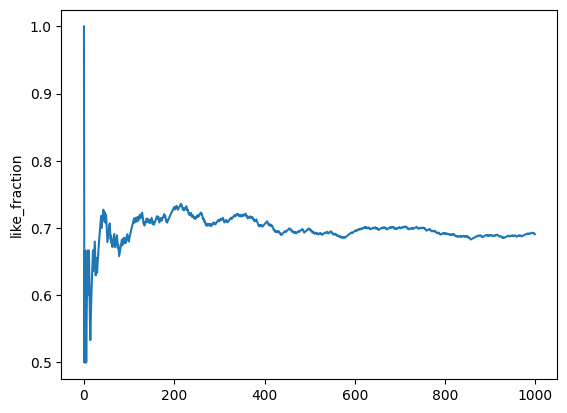

In [47]:
sns.lineplot(df_epsilon_05_results['like_fraction'])